In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 2.2 MB/s eta 0:00:01


In [ ]:
# Imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle

from os import listdir
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
DIRECTORY = "../input/yale-face-database/"

# Exploratory Data Analysis
The Yale Face Database is made from 165 grayscale images of 15 people. There are 11 images per person with different expressions. 

(243, 320, 3)


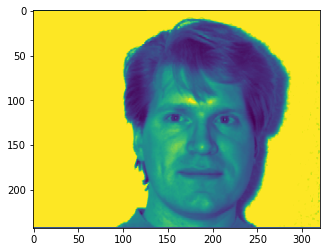

In [ ]:
filename = "../input/yale-face-database/subject01.centerlight"
pixels = plt.imread(filename)

rgb_pixels = np.stack((pixels, pixels, pixels), axis=2)
print(rgb_pixels.shape)
plt.imshow(pixels)
plt.show()

In each of the images, the face is positioned in a different region. The first task is to normalise all of the face positions so that they can reliably be fed into a classifier. There are are few techniques to achieve this. Haar Cascades provide a simple and fast method for detecting faces but they can be unreliable. They are ideally suited to real time detection. Facial identification can afford to spend longer processing the image. Therefore we will use MTCNN which is a face detection algorithm using a CNN, it achieves much higher accuracy than other techniques.

In [ ]:
# Create the detector, using default weights
detector = MTCNN()
# detect faces in the image
results = detector.detect_faces(rgb_pixels)
results

[{'box': [121, 69, 121, 153],
  'confidence': 0.9999041557312012,
  'keypoints': {'left_eye': (160, 122),
   'right_eye': (214, 123),
   'nose': (189, 152),
   'mouth_left': (163, 182),
   'mouth_right': (210, 184)}}]

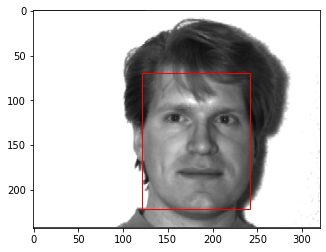

In [ ]:
# draw an image with detected objects
def draw_image_with_boxes(data, result_list):
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

# display faces on the original image
draw_image_with_boxes(rgb_pixels, results)

The next step is to extract and normalise the face pixels so that they can reliably be used for classifying.

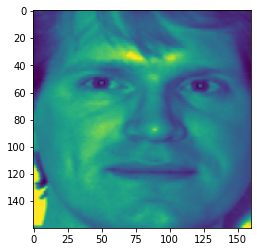

In [ ]:
# extract a single face from a given photograph
def extract_face_from_file(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    
    return extract_face(image, required_size)

def extract_face(image, required_size=(160, 160)):
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    gray_face = cv2.cvtColor(face_array, cv2.COLOR_BGR2GRAY)
    
    return gray_face


# Create the detector, using default weights
detector = MTCNN()

# load the photo and extract the face
face_pixels = extract_face_from_file("../input/yale-face-database/subject01.centerlight")

plt.imshow(face_pixels)

# Building the dataset
We need to extract the faces for all of the images so that we can create our dataset for training/testing.

In [ ]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if contains in f)

100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


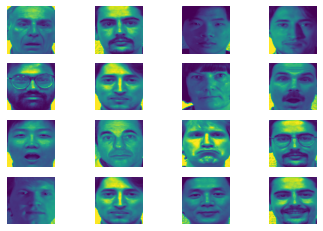

In [ ]:
i = 1
faces = list()
for filename in tqdm(list_files(DIRECTORY, "subject")[0:16]):
    # path
    path = DIRECTORY + filename
    # get face
    face = extract_face_from_file(path)
    # plot
    plt.subplot(4, 4, i)
    plt.axis('off')
    plt.imshow(face)
    faces.append(face)
    i += 1
plt.show()

# Setup the test train data

In [ ]:
# list filenames
filenames = pd.DataFrame(list_files(DIRECTORY, "subject"))

# generate split 
df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames

# # tidy columns
df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject' , '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df

,subject,category,filename
0,5,surprised,subject05.surprised
1,9,normal,subject09.normal
2,4,rightlight,subject04.rightlight
3,3,leftlight,subject03.leftlight
4,7,glasses,subject07.glasses
...,...,...,...
160,10,noglasses,subject10.noglasses
161,6,centerlight,subject06.centerlight
162,14,centerlight,subject14.centerlight
163,12,normal,subject12.normal


In [ ]:
# Print classnames
df['subject'].unique()

array([ 5,  9,  4,  3,  7, 11,  2, 14, 12,  1,  6, 15, 13,  8, 10])

## Test Train Split

There are a limited number of samples per class, although we need to a suitable number of classes in order to benchmark the models appropriately. I decided on a test train split of ~ 70/30 (enough for 3 test images).

In [ ]:
PER_CLASS = 8 # 11 images (3 test & 8 train)
NO_CLASSES = 15
DS_SIZE = df["subject"].count()
TEST_SIZE = 1 - (PER_CLASS * NO_CLASSES / DS_SIZE)

# # list files for each group
# # df.groupby(['subject'])['filename'].apply(list)
y = df['subject']
X = df.drop('subject',axis=1)

# # subject
X_train_info, X_test_info, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=45, stratify=y)

y_train = y_train.tolist()
y_test = y_test.tolist()

## Extract the faces

In [ ]:
detector = MTCNN()

def load_dataset(dataset):
    faces = list()
    for filename in tqdm(dataset["filename"]):
        path = DIRECTORY + filename
        # get face
        face = extract_face_from_file(path)
        faces.append(face)
    return np.asarray(faces)

In [ ]:
X_test = load_dataset(X_test_info)
X_train = load_dataset(X_train_info)

print(X_test.shape)
print(X_train.shape)

100%|██████████| 120/120 [00:46<00:00,  2.59it/s]

(45, 160, 160)
(120, 160, 160)


## Train the SVM Model

An SVM model gives us a good baseline as to the performance of the dataset that we can expect

In [ ]:
# develop a classifier for faces
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import random

In [ ]:
# Normalize input vectors
in_encoder = Normalizer(norm='l2')

X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
print('Reshaped X_train', X_train_reshaped.shape)
X_train_reshaped = in_encoder.transform(X_train_reshaped)

X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
print('Reshaped X_test', X_test_reshaped.shape)
X_test_reshaped = in_encoder.transform(X_test_reshaped)

# Label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)

# Fit model
model = SVC(kernel='linear', probability=True)
model.fit(X_train_reshaped, y_train)

# Predict
yhat_train = model.predict(X_train_reshaped)
yhat_test = model.predict(X_test_reshaped)

# Score
score_train = accuracy_score(y_train, yhat_train)
score_test = accuracy_score(y_test, yhat_test)
# Summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Reshaped X_train (120, 25600)
Reshaped X_test (45, 25600)
Accuracy: train=90.833, test=75.556


In [ ]:
svm_predictions = model.predict(X_test_reshaped)
print(classification_report(y_test,svm_predictions))

# Display the confusion matrix:
# [TP,FP]
print("Confusion Matrix:")
print(confusion_matrix(y_test,svm_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.40      0.67      0.50         3
           4       1.00      0.67      0.80         3
           5       1.00      0.67      0.80         3
           6       0.40      0.67      0.50         3
           7       1.00      1.00      1.00         3
           8       1.00      0.33      0.50         3
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         3
          12       0.50      0.67      0.57         3
          13       0.67      0.67      0.67         3
          14       0.67      0.67      0.67         3
          15       1.00      1.00      1.00         3

    accuracy                           0.76        45
   macro avg       0.83      0.76      0.76        45
weighted avg       0.83   

The result achieves 75% accuracy on the test set which is a fairly good result, testing other models will give us a better benchmark.

## Random Sample testing

Predicted: 14 (8.642)
Expected: 14


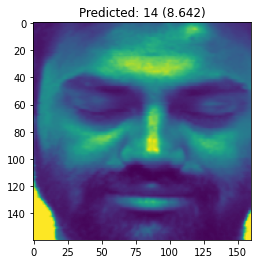

In [ ]:
# Test model on a random example from the test dataset
selection = random.randint(1, X_test.shape[0])
random_face_emb = X_test_reshaped[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class]) - 1

# prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)

# get name
class_index = yhat_class[0]

class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class) - 1
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# Show the image
plt.imshow(X_train[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

# Testing Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_reshaped, y_train)

RandomForestClassifier()

In [ ]:
rf_predictions = rfc.predict(X_test_reshaped)
print(classification_report(y_test,rf_predictions))

# Display the confusion matrix:
# [TP,FP]
print("Confusion Matrix:")
print(confusion_matrix(y_test,rf_predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.40      0.67      0.50         3
           4       1.00      1.00      1.00         3
           5       0.75      1.00      0.86         3
           6       0.33      0.67      0.44         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.33      0.50         3
          13       1.00      0.67      0.80         3
          14       1.00      0.67      0.80         3
          15       1.00      0.67      0.80         3

    accuracy                           0.82        45
   macro avg       0.90      0.82      0.83        45
weighted avg       0.90   

In [ ]:
y_test

[15,
 9,
 2,
 7,
 3,
 4,
 15,
 3,
 7,
 10,
 12,
 5,
 10,
 11,
 11,
 12,
 1,
 9,
 14,
 12,
 2,
 5,
 2,
 4,
 6,
 8,
 13,
 9,
 15,
 8,
 3,
 14,
 4,
 10,
 6,
 13,
 14,
 11,
 5,
 7,
 6,
 13,
 1,
 8,
 1]

Predicted: 2 (0.000)
Expected: 2


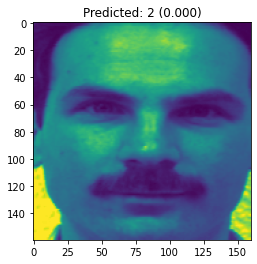

In [ ]:
# Test model on a random example from the test dataset
selection = random.randint(1, X_test.shape[0])
random_face_emb = X_test_reshaped[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class]) - 1

# Prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
yhat_class = rfc.predict(samples)
yhat_prob = rfc.predict_proba(samples)

# Get name
class_index = yhat_class[0]

# Calculate results
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class) - 1
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])

# Show the image
plt.imshow(X_test[selection])
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()

# Training a Convolutional Neural Network

In [ ]:
# Options 

TRAINING_DATA_DIRECTORY = "data/train"
TESTING_DATA_DIRECTORY = "data/test"
NUM_CLASSES = 15
EPOCHS = 25
BATCH_SIZE = 20
NUMBER_OF_TRAINING_IMAGES = 120
NUMBER_OF_TESTING_IMAGES = 45
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160

### Save the dataset to disk to load into keras

Keras has built in features to load data from disk, so we will save the dataset.

In [ ]:
import os 

def save_keras_dataset(setname, dataset, labels, per_class):
    # combine labels and images to generate files
    data = sorted(list(zip(labels, dataset)), key=lambda x: x[0])

    # Save images
    j = 0
    for label, gray_img in tqdm(data):
        j = (j% per_class) + 1
        # Create directory
        directory = f"data/{setname}/class_{label}/"
        if not os.path.exists(directory):
                os.makedirs(directory)
        cv2.imwrite(f"{directory}class_{label}_{j}.png",gray_img)

In [ ]:
y_train

[10,
 13,
 1,
 12,
 11,
 9,
 12,
 15,
 6,
 6,
 10,
 1,
 6,
 5,
 1,
 15,
 3,
 2,
 10,
 1,
 10,
 14,
 7,
 2,
 7,
 10,
 10,
 10,
 4,
 3,
 4,
 12,
 4,
 2,
 3,
 14,
 7,
 1,
 5,
 8,
 13,
 3,
 8,
 5,
 3,
 2,
 9,
 4,
 9,
 1,
 6,
 9,
 15,
 15,
 3,
 8,
 7,
 4,
 5,
 6,
 14,
 11,
 6,
 7,
 7,
 13,
 1,
 14,
 12,
 8,
 15,
 7,
 2,
 11,
 11,
 3,
 14,
 9,
 4,
 2,
 6,
 13,
 9,
 11,
 13,
 14,
 5,
 8,
 15,
 1,
 6,
 5,
 13,
 15,
 15,
 14,
 8,
 9,
 4,
 8,
 10,
 2,
 11,
 13,
 12,
 4,
 12,
 7,
 3,
 14,
 5,
 8,
 13,
 12,
 11,
 2,
 5,
 12,
 9,
 11]

In [ ]:
# clear directory if it already exists
import shutil
shutil.rmtree(r'data', ignore_errors=True)

# Save datasets
save_keras_dataset("test", X_test, y_test, 3)
save_keras_dataset("train", X_train, y_train, 8)

100%|██████████| 120/120 [00:00<00:00, 2028.18it/s]


## Configure data generators with random gaussian noise, zooming and rotation 

Keras includes an ImageDataGenerator which can automatically augment the dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def data_generator():
    return ImageDataGenerator(
        rescale=1./255,
        # horizontal_flip=True,
#         fill_mode="nearest",
#         zoom_range=0.1,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         rotation_range=10,
        # preprocessing_function=add_noise
    )

def add_noise(img):
    """Add random noise to an image"""
    VARIABILITY = 35
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [ ]:
# Setup Data Generators
training_generator = data_generator().flow_from_directory(
    TRAINING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale'
)

testing_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = data_generator().flow_from_directory(
    TESTING_DATA_DIRECTORY,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False # IMPORTANT: to ensure classes line up with batches
)

Found 120 images belonging to 15 classes.
Found 45 images belonging to 15 classes.
Found 45 images belonging to 15 classes.


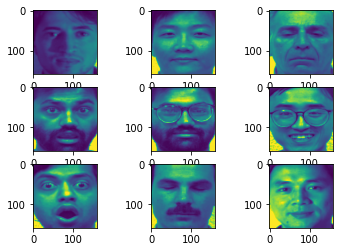

In [ ]:
sample_images = testing_generator.next()[0]

f, xyarr = plt.subplots(3,3)
xyarr[0,0].imshow(sample_images[0])
xyarr[0,1].imshow(sample_images[1])
xyarr[0,2].imshow(sample_images[2])
xyarr[1,0].imshow(sample_images[3])
xyarr[1,1].imshow(sample_images[4])
xyarr[1,2].imshow(sample_images[5])
xyarr[2,0].imshow(sample_images[6])
xyarr[2,1].imshow(sample_images[7])
xyarr[2,2].imshow(sample_images[8])
plt.show()

In [ ]:
import keras
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, ZeroPadding2D, MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers, constraints

# Define a sequential keras model
model = models.Sequential()

# 1st Convolution layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), padding='same'))
model.add(MaxPooling2D((2, 2)))

# 2nd Convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2=0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the Convolution
model.add(Flatten())

# Define a dense layer with l2 regularizer to reduce overfitting
model.add(Dense(512, activation='relu', kernel_initializer="glorot_uniform", kernel_regularizer=regularizers.l2(l2=0.01)))

# Define a drop layer to reduce overfitting
model.add(MCDropout(rate=0.5))

# Final output layer
model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer="glorot_uniform"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 160, 160, 32)      320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 78, 78, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 41472)             0

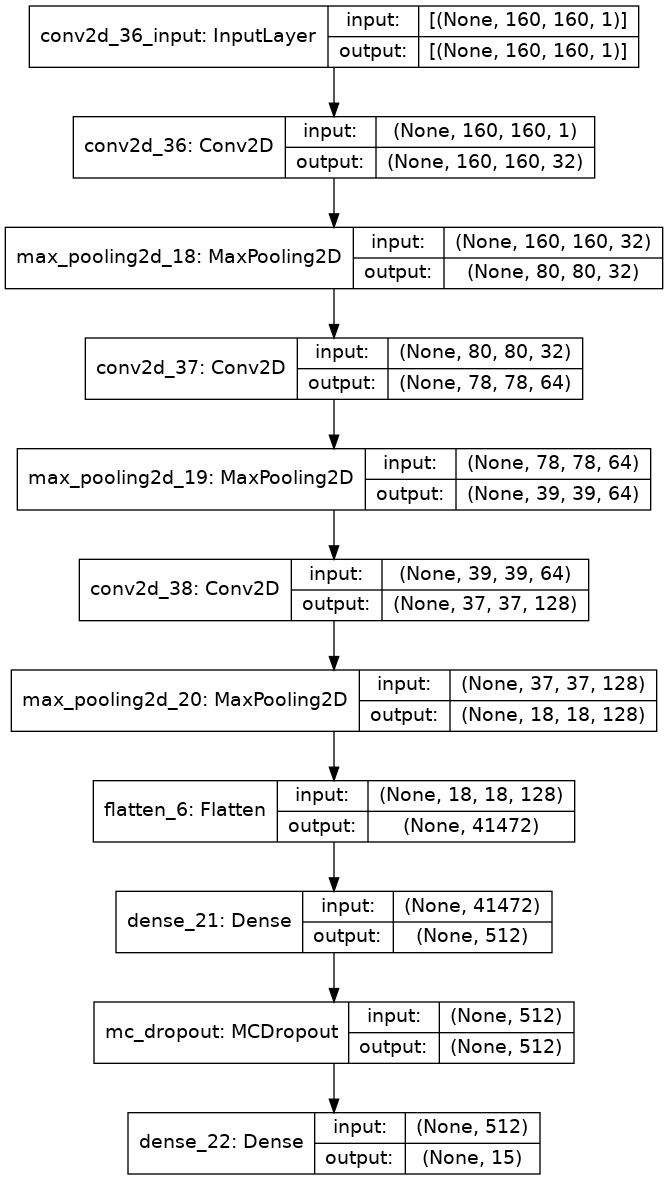

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

model.compile(
    loss=losses.CategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=0.0003),
    metrics=["accuracy"]
)

history = model.fit(
    training_generator,
    steps_per_epoch=(NUMBER_OF_TRAINING_IMAGES//BATCH_SIZE ),
    epochs=EPOCHS,
    validation_data=testing_generator,
    shuffle=True,
    validation_steps=(NUMBER_OF_TESTING_IMAGES//BATCH_SIZE),
#     callbacks=[early_stopping]
)

Epoch 1/25
6/6 [==============================] - 5s 737ms/step - loss: 13.4180 - accuracy: 0.0733 - val_loss: 10.9834 - val_accuracy: 0.0889
Epoch 2/25
6/6 [==============================] - 4s 667ms/step - loss: 10.3572 - accuracy: 0.1238 - val_loss: 8.5899 - val_accuracy: 0.1556
Epoch 3/25
6/6 [==============================] - 4s 660ms/step - loss: 8.0876 - accuracy: 0.2290 - val_loss: 6.7524 - val_accuracy: 0.2667
Epoch 4/25
6/6 [==============================] - 4s 680ms/step - loss: 6.4502 - accuracy: 0.2237 - val_loss: 5.4005 - val_accuracy: 0.2889
Epoch 5/25
6/6 [==============================] - 4s 678ms/step - loss: 5.2304 - accuracy: 0.3329 - val_loss: 4.6671 - val_accuracy: 0.3111
Epoch 6/25
6/6 [==============================] - 4s 666ms/step - loss: 4.3447 - accuracy: 0.4020 - val_loss: 3.8344 - val_accuracy: 0.5111
Epoch 7/25
6/6 [==============================] - 4s 657ms/step - loss: 3.4601 - accuracy: 0.6170 - val_loss: 3.6982 - val_accuracy: 0.4000
Epoch 8/25
6/6 [=

## CNN Model Evaluation

After training, we can evaluate the model to test its accuracy.

We need to test for overfitting which occurs when the accuracy of the training set is sigificantly higher than the testing set due to the loss function.

Implementing l2 regularization attempts to reduce overfitting by penalizing large weights in the network. Due to the small size of the dataset, there has to be a trade off between overfitting and accuracy.

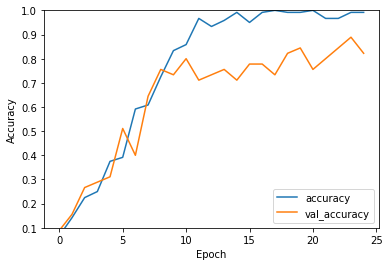

In [ ]:
plot_folder = "plot"
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

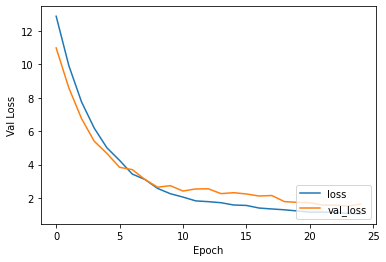

In [ ]:
plot_folder = "plot"
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend(loc='lower right')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(validation_generator.classes, y_pred))
print(validation_generator.classes)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         3
           3       1.00      0.33      0.50         3
           4       0.75      1.00      0.86         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         3
          10       0.75      1.00      0.86         3
          11       0.50      1.00      0.67         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3

    accuracy                           0.89        45
   macro avg       0.93      0.89      0.89        45
weighted avg       0.93   

## Save the model

The model can be saved for future processing

In [ ]:
MODEL_NAME = "keras_face_recognition.h5"
model_path = "./model"
if not os.path.exists(model_path):
    os.mkdir(model_path)

model.save(os.path.join(model_path, MODEL_NAME))
class_names = training_generator.class_indices
class_names_file_reverse = MODEL_NAME[:-3] + "_class_names_reverse.npy"
class_names_file = MODEL_NAME[:-3] + "_class_names.npy"
np.save(os.path.join(model_path, class_names_file_reverse), class_names)
class_names_reversed = np.load(os.path.join(model_path, class_names_file_reverse), allow_pickle=True).item()
class_names = dict([(value, key) for key, value in class_names_reversed.items()])
np.save(os.path.join(model_path, class_names_file), class_names)

# Sample Testing

In [ ]:
def get_sample_test_image():
    """Chooses a random image from the testing set"""
    
    # Choose image sample
    expected_class = random.randint(1, NUM_CLASSES)
    random_sample = random.randint(1, 3)

    # Build image path
    image_path = f"data/train/class_{expected_class}/class_{expected_class}_{random_sample}.png"

    # Read the file
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Return the results
    return img, expected_class

In [ ]:
def preprocess_image(img):
    """Ensures the image is the correct shape and normalises the pixels"""

    image = Image.fromarray(img)
    image = image.resize((160,160))
    face_array = np.asarray(image)
    # expands the dimensions
    face_array = face_array.reshape(160,160,1)

    face_array = face_array.astype('float32')
    scaled_image = np.expand_dims(face_array, axis=0)

    return scaled_image

In [ ]:
def prediction(image, debug=True): 
    # show the image
    plt.imshow(image)
    plt.show()

    # Process the sample
    input_sample = preprocess_image(img) 

    # Prediction
    results = model.predict(input_sample)
    result = np.argmax(results, axis=1)
    index = result[0]

    # Calculate Confidence
    confidence = results[0][index] * 100
    classes = np.load(os.path.join("model", class_names_file), allow_pickle=True).item()
    # Get class name
    if type(classes) is dict:
        for k, v in classes.items():
            if k == index:
                class_name = v
    if debug:
        print(results)
        print("Detected class is {} with {:.2f}% confidence".format(class_name, round(confidence, 2)))
    
    # Return results
    return class_name, confidence

Expected class: 10


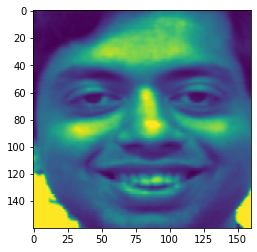

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Detected class is class_10 with 100.00% confidence


(('class_10', 100.0), 'expected:10')

In [ ]:
# Choose an image
img, expected_class = get_sample_test_image()

print(f"Expected class: {expected_class}")

prediction(img), f"expected:{expected_class}"